In [332]:
# turn data - previous 5 turns
# state data - cumulative turn data
# base data - matchup

# GT - winner

### REGRESSOR 3 - base data

In [333]:
import pandas as pd

display(winners := pd.read_csv('datasets/clean/winners.tsv', header=None, index_col=None, sep='\t').values)

array([[7.500e+01, 1.100e+02, 1.050e+02, ..., 1.063e+03, 1.000e+03,
        1.000e+00],
       [8.500e+01, 6.000e+01, 1.000e+02, ..., 1.591e+03, 1.537e+03,
        0.000e+00],
       [3.500e+01, 5.500e+01, 4.000e+01, ..., 1.569e+03, 1.680e+03,
        0.000e+00],
       ...,
       [7.400e+01, 7.500e+01, 7.000e+01, ..., 1.000e+03, 1.000e+03,
        0.000e+00],
       [2.000e+01, 1.000e+01, 5.500e+01, ..., 1.000e+03, 1.000e+03,
        0.000e+00],
       [6.800e+01, 6.400e+01, 6.000e+01, ..., 1.000e+03, 1.000e+03,
        1.000e+00]])

In [334]:
from sklearn.model_selection import train_test_split

labels = winners[:, -1]
entries = winners[:, :-1]
train_X, test_X, train_y, test_y = train_test_split(entries, labels, test_size=0.3)

In [335]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

lr = Lasso(alpha=0.01).fit(train_X, train_y)
display(lr.score(test_X, test_y))
display(lr.score(train_X, train_y))

testx, testy = list(zip(*sorted(list(zip(test_X, test_y)), key=lambda x: x[1])))
predy = lr.predict(testx)

-0.025608661993866244

0.051785314123714676

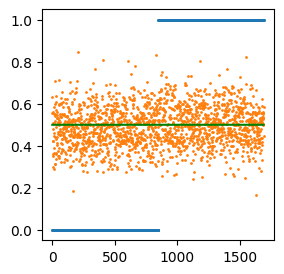

In [161]:
from matplotlib import pyplot as plt

plt.scatter(range(len(testy)), testy, s=1)
plt.scatter(range(len(testy)), predy, s=1)
plt.plot(range(len(testy)), [0.5]*len(testy), c='g')


In [148]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_X)


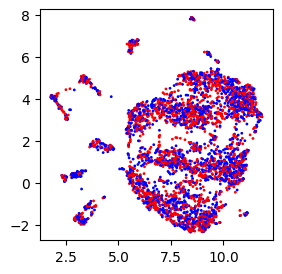

In [149]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x)] for x in train_y],
  s=1)
plt.gca().set_aspect('equal', 'datalim')


In [150]:
import sklearn

embedding = sklearn.decomposition.PCA(n_components=2).fit_transform(train_X)


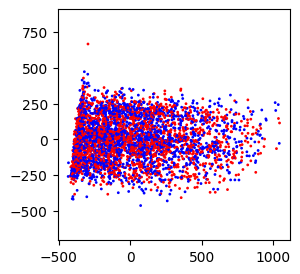

In [151]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x)] for x in train_y],
  s=1)
plt.gca().set_aspect('equal', 'datalim')

In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

regressor = DecisionTreeClassifier()
regressor.fit(train_X, train_y.astype(int))
regressor.score(test_X, test_y.astype(int))


0.5286812536960378

precision: 0.4994026284348865
recall: 0.4958481613285884
f1: 0.4976190476190477
accuracy: 0.5008870490833827


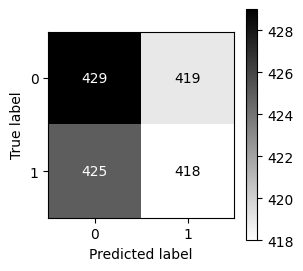

In [168]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

predy = regressor.predict(test_X)
plt.rcParams['figure.figsize'] = [3, 3]

testy = [int(x) for x in testy]
disp = ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(testy, predy))
disp.plot(cmap='binary')
print(f'precision: {precision_score(testy, predy)}')
print(f'recall: {recall_score(testy, predy)}')
print(f'f1: {f1_score(testy, predy)}')
print(f'accuracy: {accuracy_score(testy, predy)}')



### CNN BASED

In [482]:
import json

import numpy as np

ti, tl, tei, tel = [], [], [], []
for SLICESIZE in [5, 10, 15, 20]:
	with open(f'datasets/clean/slices_{SLICESIZE}.json') as fl:
		_data = json.load(fl)

	train_images, train_labels = list(zip(
		*[(np.array(img), label) for img, label in
			zip(_data['train_X'], _data['train_y'])
			if np.array(img).shape == np.array(_data['train_X'][0]).shape]
	))

	test_images, test_labels = list(zip(
		*[(np.array(img), label) for img, label in
			zip(_data['test_X'], _data['test_y'])
			if np.array(img).shape == np.array(_data['test_X'][0]).shape]
	))

	train_labels, test_labels = np.array(train_labels, dtype=int), np.array(test_labels, dtype=int)

	img = np.mean(train_images, axis=0)
	train_images = [x / img.max(axis=0) for x in train_images]
	test_images = [x / img.max(axis=0) for x in test_images]
	train_images, test_images = np.array(train_images), np.array(test_images)

	train_images = train_images.reshape(len(train_labels), SLICESIZE, 38, 1)
	test_images = test_images.reshape(len(test_labels), SLICESIZE, 38, 1)

	ti.append(train_images)
	tl.append(train_labels)
	tei.append(test_images)
	tel.append(test_labels)



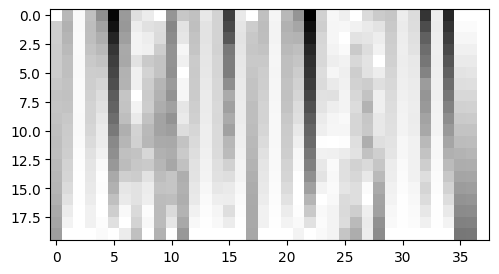

In [483]:
plt.figure(figsize=(10, 3))
all_images = np.concatenate((train_images, test_images), axis=0)
img = np.mean(all_images, axis=0)
plt.grid(False)
plt.imshow(img / img.max(axis=0), cmap='gray')

train_images = [x / img.max(axis=0) for x in train_images]
test_images = [x / img.max(axis=0) for x in test_images]
train_images, test_images = np.array(train_images), np.array(test_images)

In [484]:
from sklearn.metrics import confusion_matrix

def evaluate_classifier(y_true, y_pred):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
  disp.plot(cmap='binary')
  print(f'accuracy: {accuracy_score(np.squeeze(y_true), np.squeeze(y_pred))}')
  print(f'precision: {precision_score(np.squeeze(y_true), np.squeeze(y_pred))}')
  print(f'recall: {recall_score(np.squeeze(y_true), np.squeeze(y_pred))}')
  print(f'f1 score: {f1_score(np.squeeze(y_true), np.squeeze(y_pred))}')


In [485]:
from keras.callbacks import EarlyStopping
from keras import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#### SIZEFIVE MODEL


In [486]:
train_X, train_y, test_X, test_y = ti[0], tl[0], tei[0], tel[0]

sizefive_model = Sequential()
sizefive_model.add(Conv2D(32, (2, 26), activation='relu', input_shape=(5, 38, 1)))
sizefive_model.add(MaxPooling2D((2, 4)))
sizefive_model.add(Conv2D(64, (2, 2), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
sizefive_model.add(Flatten())
sizefive_model.add(Dense(64, activation='relu'))
sizefive_model.add(Dropout(0.4))
sizefive_model.add(Dense(8, activation='relu'))
sizefive_model.add(Dropout(0.1))
sizefive_model.add(Dense(1, activation='sigmoid'))

sizefive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[], run_eagerly=True)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = sizefive_model.fit(train_X, train_y.astype(float), epochs=50, batch_size=256, validation_split=0.3, callbacks=[early_stop])


Epoch 1/50
61/61 [==============================] - 5s 79ms/step - loss: 0.7032 - val_loss: 0.6933
Epoch 2/50
61/61 [==============================] - 5s 78ms/step - loss: 0.6935 - val_loss: 0.6928
Epoch 3/50
61/61 [==============================] - 4s 68ms/step - loss: 0.6932 - val_loss: 0.6928
Epoch 4/50
61/61 [==============================] - 4s 72ms/step - loss: 0.6927 - val_loss: 0.6923
Epoch 5/50
61/61 [==============================] - 4s 69ms/step - loss: 0.6921 - val_loss: 0.6918
Epoch 6/50
61/61 [==============================] - 4s 69ms/step - loss: 0.6900 - val_loss: 0.6896
Epoch 7/50
61/61 [==============================] - 4s 74ms/step - loss: 0.6875 - val_loss: 0.6879
Epoch 8/50
61/61 [==============================] - 4s 69ms/step - loss: 0.6828 - val_loss: 0.6832
Epoch 9/50
61/61 [==============================] - 4s 69ms/step - loss: 0.6751 - val_loss: 0.6710
Epoch 10/50
61/61 [==============================] - 4s 73ms/step - loss: 0.6646 - val_loss: 0.6641
Epoch 11/

296/296 [==============================] - 2s 8ms/step
accuracy: 0.5947719335379406
precision: 0.5716083036275948
recall: 0.6041666666666666
f1 score: 0.587436698631613


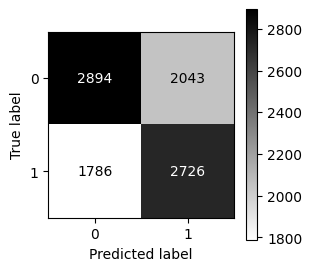

In [487]:
evaluate_classifier(np.squeeze(np.round(sizefive_model.predict(test_X))), test_y.astype(float))

#### SIZETEN MODEL

In [488]:
train_X, train_y, test_X, test_y = ti[1], tl[1], tei[1], tel[1]
sizeten_model = Sequential()
sizeten_model.add(Conv2D(32, (4, 26), activation='relu', input_shape=(10, 38, 1)))
sizeten_model.add(MaxPooling2D((2, 4)))
sizeten_model.add(Conv2D(64, (2, 2), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
sizeten_model.add(Flatten())
sizeten_model.add(Dense(64, activation='relu'))
sizeten_model.add(Dropout(0.4))
sizeten_model.add(Dense(8, activation='relu'))
sizeten_model.add(Dropout(0.1))
sizeten_model.add(Dense(1, activation='sigmoid'))

sizeten_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[], run_eagerly=True)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = sizeten_model.fit(train_X, train_y.astype(float), epochs=50, batch_size=256, validation_split=0.3, callbacks=[early_stop])


Epoch 1/50
46/46 [==============================] - 5s 116ms/step - loss: 0.7103 - val_loss: 0.6932
Epoch 2/50
46/46 [==============================] - 6s 129ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 3/50
46/46 [==============================] - 7s 143ms/step - loss: 0.6934 - val_loss: 0.6927
Epoch 4/50
46/46 [==============================] - 6s 120ms/step - loss: 0.6923 - val_loss: 0.6916
Epoch 5/50
46/46 [==============================] - 4s 91ms/step - loss: 0.6889 - val_loss: 0.6921
Epoch 6/50
46/46 [==============================] - 4s 89ms/step - loss: 0.6846 - val_loss: 0.6863
Epoch 7/50
46/46 [==============================] - 4s 96ms/step - loss: 0.6768 - val_loss: 0.6720
Epoch 8/50
46/46 [==============================] - 4s 90ms/step - loss: 0.6538 - val_loss: 0.6388
Epoch 9/50
46/46 [==============================] - 4s 91ms/step - loss: 0.6157 - val_loss: 0.6093
Epoch 10/50
46/46 [==============================] - 5s 111ms/step - loss: 0.5701 - val_loss: 0.5804
Epoc

217/217 [==============================] - 2s 10ms/step
accuracy: 0.5864759427828349
precision: 0.5042886719905354
recall: 0.5897613282601176
f1 score: 0.543686224489796


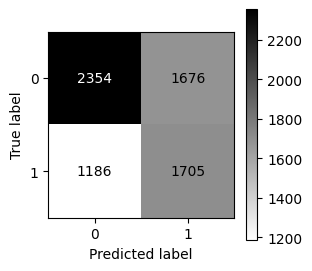

In [489]:
pred = np.squeeze(np.round(sizeten_model.predict(test_X)))
evaluate_classifier(test_y, pred)

0.7309989142236699

0.7234933035714285